# BEEF: Bayesian Error Estimate Functionals

Matthew Evans  
Electronic Structure Discussion Group  
10/10/2018  

## Motivation
- Difficult to quantify intrinsic errors in DFT.
- Typically repeat calculations with several functionals to validate.
- Can we say anything about the confidence of our results?

### Worst case scenario:

- Predicting that a phase is stable, when its not.
- vice versa


Not so bad?

- Often want to compute relative energies of materials that exhibit different physics:
    - can we always get away with error cancellation?

## Plan of attack

- Ignore all of physics
- ~~least-squares fit~~ MACHINE LEARN new functional from experimental database.
- use modern (2005) computing power to observe the effect of perturbations of this functional to build up probabilistic model.

*Bayesian Error Estimation in Density-Functional Theory*  
J. J. Mortensen, K. Kaasbjerg, S. L. Frederiksen, J. K. Nørskov, J. P. Sethna, and K. W. Jacobsen  
PRL **95**, 216401 (2005)  
[10.1103/PhysRevLett.95.216401](https://doi.org/10.1103/PhysRevLett.95.216401)  
(76 citations)

## BEEF

Going to consider PBE-like GGA-DFT exchange functionals: just a local functional of density $n$ and $s$, where

$$ s(n, \nabla n) = \frac{|\nabla n|}{2k_F n}. $$

Each of PW-91, PBE, revPBE and RPBE differ only in their parameterisation of the enhancement factor in the exchange energy $F_x[s(n, \nabla n)]$:

$$ E_x[n] = \int \mathrm{d}\mathbf{r}\, n(\mathbf{r}) \varepsilon_x^\text{LDA}(n(\mathbf{r}))F_x[s(n, \nabla n)].$$

e.g. PBE $F_x(s)$:

$$ F^\text{PBE}_x(s) = 1 + \kappa - \kappa\left({1 + \frac{\mu s^2}{\kappa}}\right)^{-1}, $$

with $\kappa = 0.804$ and $\mu = 0.219$ derived analytically.

Perdrew, Burke & Ernzerhof "Generalised gradient approximation made simple", PRL **77**, 3865 (1996) [10.1103/PhysRevLett.77.3865](https://doi.org/10.1103/PhysRevLett.77.3865) (46,656 citations)

In [1]:
import numpy as np
s = np.linspace(0, 3, 100)
Fx_GGA = lambda κ, µ: 1 + κ - κ / (1 + (µ * s**2 / κ))
Fx_GGA_exp = lambda κ, µ: 1 + κ * (1 - np.exp(-µ * s**2 / κ))
Fx_LDA = 1 + 0*s

Fx_PBE = Fx_GGA(0.804, 0.219)      # Perdrew, Burke & Enzerhof, PRL 77(18), 3865 (1996) 10.1103/PhysRevLett.77.3865 (46,656 citations)
Fx_revPBE = Fx_GGA(1.245, 0.219)   # Zhang & Yang, PRL 80(4) 890-890 (1998) 10.1103/PhysRevLett.80.890 (957 citations)
Fx_RPBE = Fx_GGA_exp(0.804, 0.219) # Hammer, Hansen & Norskov, PRB 59(11) (1999) 7413-7421 10.1103/physrevb.59.7413 (2442 citations)

In [2]:
def plotting_boilerplate():
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style('white')
    sns.set_context('talk')
    sns.set_palette('deep')
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$s$')
    ax.set_ylabel('$F_x(s)$')
    ax.set_ylim(0.8, 2)
    ax.set_xlim(0, 3)
    sns.despine()
    return ax

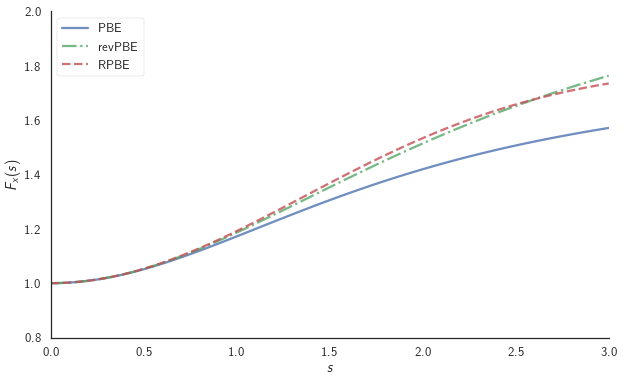

In [3]:
ax = plotting_boilerplate()
ax.plot(s, Fx_PBE, label='PBE', alpha=0.8, ls='-')
ax.plot(s, Fx_revPBE, label='revPBE', alpha=0.8, ls='-.')
ax.plot(s, Fx_RPBE, label='RPBE', alpha=0.8, ls='--')
_ = ax.legend(loc='upper left', fancybox=True, frameon=True, framealpha=1)

## Fitting a new functional

Simple expansion of GGA model:

$$ F_x(s) = \sum_{i=1}^{N_p} \theta_i \left(\frac{s}{1+s}\right)^{2i-2}. $$

Restrict to $N_p=3$ to avoid overfitting.

## Putting the Bayes into database

Minimise least-squares cost function across database of experimental atomisation/cohesive energies $E_k^\text{exp}$:

$$ C(\theta) = \frac{1}{2} \sum_k (E_k(\theta) - E_k^\text{exp})^2. $$

## Very simple database!

Molecules:

H<sub>2</sub>, LiH, CH<sub>4</sub>, NH<sub>3</sub>, OH, H<sub>2</sub>O, HF, Li<sub>2</sub>, LiF, Be<sub>2</sub>, C<sub>2</sub>H<sub>2</sub>, C<sub>2</sub>H<sub>4</sub>, HCN, CO, N<sub>2</sub>, NO, O<sub>2</sub>, F<sub>2</sub>, P<sub>2</sub>, Cl<sub>2</sub>.


Solids:

Na, Li, Si, C, SiC, AlP, MgO, NaCl, LiF, Cu, Pt.

Uniform weight across all entries.

## Fitting procedure:

1. Calculate electron density self-consistently using PBE.
2. Evaluate exchange-correlation energy for ensemble of functionals
$$ E(\theta) = E_0 + \sum_{i=1}^3 \Delta E_i \theta_i, $$
*non-self-consistently* on the PBE density.
3. Adjust $\theta$ to minimise cost function (least squares error).

In [4]:
def Fx_BEEF(s, thetas=[1.0008, 0.1926, 1.8962]):
    Fx = np.zeros_like(s)
    for i in range(3):
        Fx += thetas[i] * (s / (1+s))**(2*(i+1)-2)
    return Fx

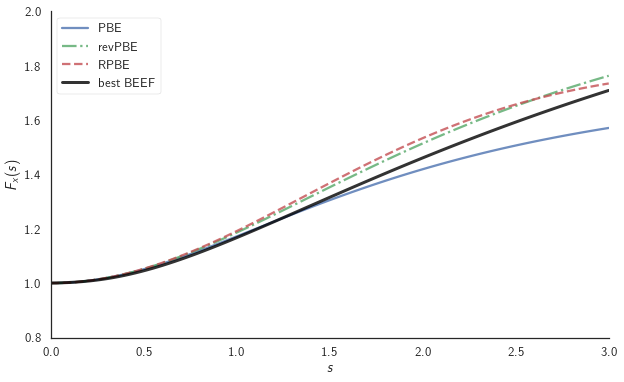

In [5]:
ax = plotting_boilerplate()
ax.plot(s, Fx_PBE, label='PBE', alpha=0.8, ls='-')
ax.plot(s, Fx_revPBE, label='revPBE', alpha=0.8, ls='-.')
ax.plot(s, Fx_RPBE, label='RPBE', alpha=0.8, ls='--')
ax.plot(s, Fx_BEEF(s), alpha=0.8, label='best BEEF', c='k', lw=3)
_ = ax.legend(loc='upper left', fancybox=True, frameon=True, framealpha=1)

Fitting finds $F_x(0)=1$ naturally.

For $s>1.5$, fitting ends up somewHere between PBE and RPBE.

> "We would like to stress that the main point of this Letter is not to derive an improved functional..."

> "and we do not expect to obtain a large overall improvement within this simple GGA framework. But as we shall see in the following the ensemble construction allows for realistic evaluation of the error bars on calculated quantities."

## Generating a probabilistic ensemble of functionals

We would expect the probability of finding parameters $\theta$ given our model $M$ and the database $D$ to be:

$$ P(\theta|MD) \sim \exp{\left(-\frac{C(\theta)}{T}\right)}, $$

where $T$ is some effective temperature related to the number of degrees of freedom and $C(\theta)$ is our least squares cost function wrt. experimental database.

Turns out that the least square cost function is very close to harmonic in the relevant region of parameter space, so we can expand this:
    
$$ \frac{C(\theta)}{T} = \text{const.} + \frac{1}{2}\Delta \theta^T A \Delta \theta, $$

where $A$ is a symmetric matrix and $U$ being the matrix that diagonalises $A$ such that $AU = U\Lambda$. Leading to

$$ \theta = \theta_\text{bf} + U \Lambda^{-1/2} \alpha, $$

for vector $\alpha$ with elements $\alpha_i$ such that $\mathcal{P}(\alpha_i) \sim \exp{(-\alpha_i^2/2)}$.

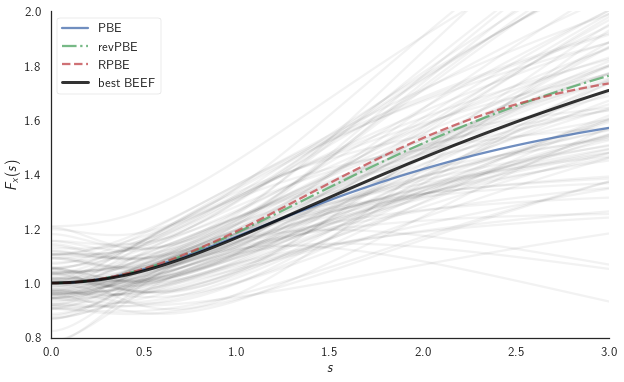

In [6]:
ax = plotting_boilerplate() 

U_over_sqrtlambda = np.matrix([[0.066, 0.055, -0.034], [-0.812, 0.206, 0.007], [1.996, 0.082, 0.004]])
theta_bf = [1.0008, 0.1926, 1.8962]
N = 100
for _ in range(N):
    alpha = np.random.normal(size=(3))
    thetas = theta_bf + np.asarray((U_over_sqrtlambda @ alpha))[0]
    ax.plot(s, Fx_BEEF(s, thetas=thetas), alpha=5/N, c='k')
    
ax.plot(s, Fx_PBE, label='PBE', alpha=0.8, ls='-')
ax.plot(s, Fx_revPBE, label='revPBE', alpha=0.8, ls='-.')
ax.plot(s, Fx_RPBE, label='RPBE', alpha=0.8, ls='--')
ax.plot(s, Fx_BEEF(s), alpha=0.8, label='best BEEF', c='k', lw=3)
_ = ax.legend(loc='upper left', fancybox=True, frameon=True, framealpha=1)

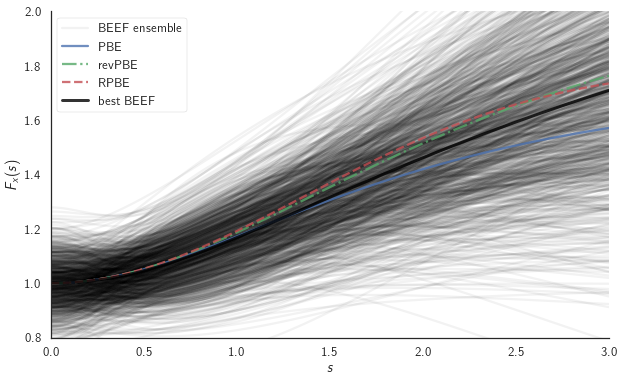

In [7]:
ax = plotting_boilerplate() 

U_over_sqrtlambda = np.matrix([[0.066, 0.055, -0.034], [-0.812, 0.206, 0.007], [1.996, 0.082, 0.004]])
theta_bf = [1.0008, 0.1926, 1.8962]
N = 1000
for i in range(N):
    label = None
    if i == 0:
        label = 'BEEF ensemble'
    alpha = np.random.normal(size=(3))
    thetas = theta_bf + np.asarray((U_over_sqrtlambda @ alpha))[0]
    ax.plot(s, Fx_BEEF(s, thetas=thetas), alpha=0.05, c='k', label=label)

ax.plot(s, Fx_PBE, label='PBE', alpha=0.8, ls='-')
ax.plot(s, Fx_revPBE, label='revPBE', alpha=0.8, ls='-.')
ax.plot(s, Fx_RPBE, label='RPBE', alpha=0.8, ls='--')
ax.plot(s, Fx_BEEF(s), alpha=0.8, label='best BEEF', c='k', lw=3)
_ = ax.legend(loc='upper left', fancybox=True, frameon=True, framealpha=1)

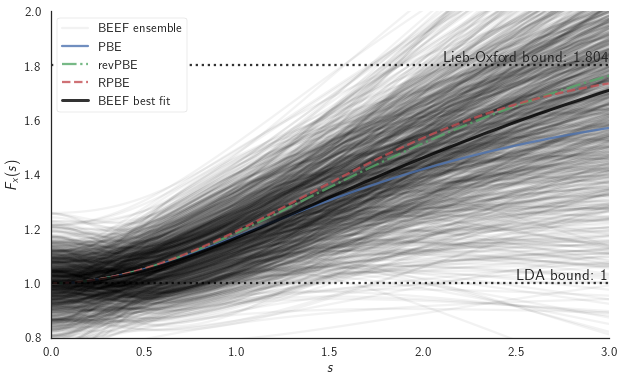

In [8]:
ax = plotting_boilerplate() 

U_over_sqrtlambda = np.matrix([[0.066, 0.055, -0.034], [-0.812, 0.206, 0.007], [1.996, 0.082, 0.004]])
theta_bf = [1.0008, 0.1926, 1.8962]
error = np.zeros_like(s)
N = 1000
for i in range(N):
    label = None
    if i == 0:
        label = 'BEEF ensemble'
    alpha = np.random.normal(size=(3))
    thetas = theta_bf + np.asarray((U_over_sqrtlambda @ alpha))[0]
    ax.plot(s, Fx_BEEF(s, thetas=thetas), alpha=50/N, c='k', label=label)

ax.plot(s, Fx_PBE, label='PBE', alpha=0.8, ls='-')
ax.plot(s, Fx_revPBE, label='revPBE', alpha=0.8, ls='-.')
ax.plot(s, Fx_RPBE, label='RPBE', alpha=0.8, ls='--')
ax.plot(s, Fx_BEEF(s), alpha=0.8, label='BEEF best fit', c='k', lw=3)
ax.plot(s, len(s)*[1.804], alpha=0.8, ls=':', c='k')
ax.text(3, 1.804, 'Lieb-Oxford bound: 1.804', verticalalignment='bottom', horizontalalignment='right')
ax.plot(s, len(s)*[1], alpha=0.8, ls=':', c='k')
ax.text(3, 1, 'LDA bound: 1', verticalalignment='bottom', horizontalalignment='right')
_ = ax.legend(loc='upper left', fancybox=True, frameon=True, framealpha=1)

### Lieb-Oxford Bound:

$$ \begin{align} E_X[n_\uparrow, n_\downarrow] &\geq E_{XC}[n_\uparrow, n_\downarrow] \\ & \geq -1.679e^2 \int \mathrm{d}^3r\, n^{4/3} \implies F_X(s) \leq 1.804. \end{align}$$ 

As you can see, the spread of the ensemble is much greater than the difference between the best fit and the well-known functionals, can alternatively calculate errors wrt. PBE result.

## Bayesian error estimate (BEE)

Thus, we can generate a properly distributed ensemble of enhancement factors around the best fit. Can therefore define error on any arbitrary observable $O$ in the standard way:

$$ \sigma_\text{BEE}(O) = \sqrt{\frac{1}{N} \sum_{\mu=1}^N (O(\theta^\mu) - O_\text{bf})^2}. $$

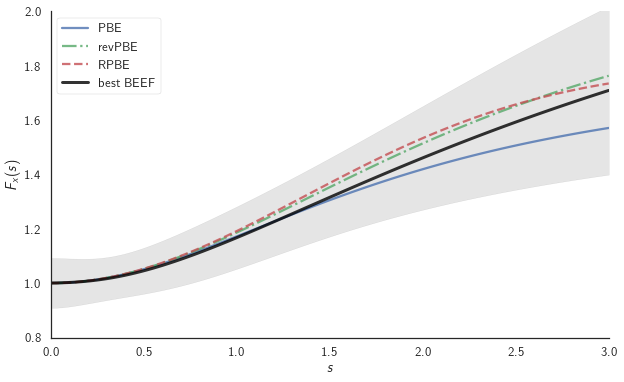

In [9]:
ax = plotting_boilerplate() 

U_over_sqrtlambda = np.matrix([[0.066, 0.055, -0.034], [-0.812, 0.206, 0.007], [1.996, 0.082, 0.004]])
theta_bf = [1.0008, 0.1926, 1.8962]
error = np.zeros_like(s)
N = 1000
for i in range(N):
    label = None
    if i == 0:
        label = 'BEEF ensemble'
    alpha = np.random.normal(size=(3))
    thetas = theta_bf + np.asarray((U_over_sqrtlambda @ alpha))[0]
    error += (Fx_BEEF(s, thetas=thetas) - Fx_BEEF(s, thetas=theta_bf))**2
error = np.sqrt(error / N)

ax.plot(s, Fx_PBE, label='PBE', alpha=0.8, ls='-')
ax.plot(s, Fx_revPBE, label='revPBE', alpha=0.8, ls='-.')
ax.plot(s, Fx_RPBE, label='RPBE', alpha=0.8, ls='--')
ax.plot(s, Fx_BEEF(s), alpha=0.8, label='best BEEF', c='k', lw=3)
ax.fill_between(s, Fx_BEEF(s)+error, Fx_BEEF(s)-error, color='k', alpha=0.1)
_ = ax.legend(loc='upper left', fancybox=True, frameon=True, framealpha=1)

## Errors on observables

<center><img src="https://journals.aps.org/prl/article/10.1103/PhysRevLett.95.216401/figures/2/medium" align="center"/>
Fig 2, Mortensen et al. PRL 95.</center>

## Fast-forward to 2012:

- We know PBE is "wrong"
- One large source of errors are dispersion forces, or van der Waals (vdW) forces.
    - "correlations in the fluctuating polarisations of nearby atoms"
- Can we fit a BEEF-style functional?

*Density functionals for surface science: Exchange-correlation model development with Bayesian error estimation*  
Jess Wellendorff, Keld T. Lundgaard, Andreas Møgelhøj, Vivien Petzold, David D. Landis, Jens K. Nørskov, Thomas Bligaard, and Karsten W. Jacobsen
PRB **85**, 235149  
[10.1103/PhysRevB.85.235149](https://doi.org/10.1103/PhysRevB.85.235149)  
(300 citations)

## Towards BEEF-vdW:

### I. Data sets


- **Molecular formation energies** of ~300 molecules from the Gaussian-3 (1999) test set **(G3/99)**.
- **Molecular reaction energies** of 42 different reactions **(RE42)**.
- **Molecular reaction barriers**: 12 forward and 12 backward reaction barriers **(DBH24/08)**.
- **Noncovalent interactions**: intermolecular interaction energies of noncovalently bonded complexes calculated with CCSD(T) **(S22 and S22x5)**.
- **Solid state properties**: 
    - cohesive energies of 35 solids in fcc, bcc, diamond and hcp lattices, without ZPM corrections **(Sol34Ec)**.
    - lattice constants and cohesive energies for 27 cubic lattices, corrected for ZPM. **(Sol27Lc and Sol27Ec)**.
- **Chemisorption on solid surfaces**: reaction energies of simple molecules on [111], [100] and [001] facets of late-transition metals **(CE27)**.

- Again, self-consistent DFT performed to predict all of the above data.

## Towards BEEF-vdW

### II. Model space

- Focus on "rung 3.5" of Jacob's ladder, the vdW-DF approximation.
    - Dion, Rydberg, Schroder, Langreth and Lundqvist, PRL **92** 246401 (2004), [10.1103/PhysRevLett.92.246401](https://doi.org/10.1103/PhysRevLett.92.246401), 2602 citations.
    - fully nonlocal functional of the ground-state density without explicit use of KS orbitals.
        $$ E^{\text{nl-}c}[n] = \frac{1}{2} \int \mathrm{d}\mathbf{r}\,\mathrm{d}\mathbf{r}' n(\mathbf{r}) \phi(\mathbf{r}, \mathbf{r}')n(\mathbf{r}'), $$
       where $\phi(\mathbf{r}, \mathbf{r}')$ is some nonlocal interaction kernel.

- GGA exchange part stays almost the same, slightly different expansion into Legendre polynomials $B_m[t(s)]$, where

$$ t(s) = \frac{2s^2}{4+s^2} - 1,\quad\text{s.t.}\quad -1\leq t \leq 1, $$
and thus

$$ F^\text{GGA}_x(s) = \sum_m a_m B_m[t(s)]. $$

The exchange energy is then given by,

$$ \begin{align} E^{\text{GGA-}x}[n, \nabla n] &= \sum_m a_m \int \mathrm{d}\mathbf{r}\,\varepsilon_x^\text{LDA}(n) B_m[t(s)] \\ &= \sum_m \alpha_m E^{\text{GGA-}x}_m[n, \nabla n].\end{align} $$

- Semilocal approximations are not amenable to a simple description, e.g. in terms of $s(n, \nabla n)$.
    - Wellendorff et al. choose the correlation model space to consist of a linear combination of: 
        - semilocal PBE correlation,
        - local LDA correlation 
        - nonlocal correlation in style of vdW-DF2, as previously stated.

Putting all this together:

$$ E_{xc} = \sum_{m=0}^{M_x} a_m E_m^{\text{GGA-x}} + \alpha_c E^{\text{LDA-}c} + (1-\alpha_c) E^{\text{PBE-}c} + E^{\text{nl-}c}. $$

for $M_x =30$ and thus $M=31$ when including $\alpha_c$.

## Towards BEEF-vdW

### III. Model selection

- With 31 parameters, need to be very careful not to overfit:
    - Can control overfitting with **regularisation**, e.g. Tikhonov regularisation, which modifies the cost function to include a prior.
    
        $$ C(\theta) = \sum_k (E_k(\theta) - E_k^\text{exp})^2 + \omega^2 \Gamma^2(\mathbf{\theta - \theta_p}^2). $$
        
    - Here $E_k(\theta)$ evaluated on RPBE densities.
    - Prior model chosen to obey LDA/LO limits (e.g. PBE).
    - Now vary regularisation strength $\omega$ to minimise "estimated prediction error" (EPE), typically computed by bootstrapping resampling.

#### Train on individual databases:

<center><img src="https://journals.aps.org/prb/article/10.1103/PhysRevB.85.235149/figures/1/medium">
Fig 1, Wellendorff et al. PRB 85.</center>

#### Run models on the other data sets:

<center><img src="https://journals.aps.org/prb/article/10.1103/PhysRevB.85.235149/figures/2/medium">
Fig 2, Wellendorff et al. PRB 85.</center>

### Model compromise:

- How do we want to choose the model?
    - Jack of all trades, and master of...
    - Tune to desired properties/system at hand?


### BEEF-vdW choice: 

Minimise product cost function, given arbitrary personal preference choices of weights $w_i$:

$$ \Phi(\theta) = \prod_i C_i(\theta)^{w_i}. $$

## The result:
<center><img src="https://journals.aps.org/prb/article/10.1103/PhysRevB.85.235149/figures/4/medium">
Fig 4, Wellendorff et al. PRB 85.</center>

- Doesn't quite obey either LDA limit (1) $F_x(s=0) = 1.034$ or LO limit (1.804) $F(s=\infty)=1.870$.
- Shoulder at $\sim s=1.3$ requires very strong regularisation to remove.

## Can still estimate errors:

<center><img src="https://journals.aps.org/prb/article/10.1103/PhysRevB.85.235149/figures/5/medium">
Fig 5, Wellendorff et al. PRB 85.
</center>

## Benchmarking against other functionals:
<center><img src="https://journals.aps.org/prb/article/10.1103/PhysRevB.85.235149/figures/6/medium">
Fig 6, Wellendorff et al. PRB 85.
</center>

## Benchmarking against other functionals:
<center><img src="https://journals.aps.org/prb/article/10.1103/PhysRevB.85.235149/figures/9/medium" align='center'>
Fig 9, Wellendorff et al. PRB 85.
</center>

### Availability

- plugin to libxc on GitHub, (github.com/vossjo/libbeef)[https://github.com/vossjo/libbeef]
- specific implementations for VASP and Quantum Espresso (github.com/vossjo/q-e)[https://github.com/vossjo/q-e]
- Native support in Python packages GPAW and ASE (https://wiki.fysik.dtu.dk/gpaw/devel/projects/beef.html)[https://wiki.fysik.dtu.dk/gpaw/devel/projects/beef.html]

### Possible discussion points

1. Why isn't everyone using this?
    - What other alternatives do we have for comparing vastly different structures?
2. How can we factor in these uncertainties into high-throughput calculations/screening?
3. Is this really the most useful thing to be doing? Resulting functional will never be "better" as it is always confined to the model space.
    - worth doing hybrids/hypers?